In [1]:
#インポート
!pip install --upgrade gensim
from gensim.models import word2vec
from nltk.stem.porter import PorterStemmer as PS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
#マウント
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/検索技術

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/検索技術


In [3]:
#前処理
def preprocess(text,eliminate=0):
  text=text.lower()       #小文字化
  text=text.replace('.','')     #以下で記号と単語の間にスペースを挿入したり削除したりする。
  text=text.replace(',','')
  text=text.replace('\n','')
  text=text.replace('\t',' ')
  text=text.replace('(','')
  text=text.replace(')','')
  text=text.replace('!','')
  text=text.replace('?','')
  text=text.replace('"','')
  words=text.split(' ')   #スペースで区切り、リスト化する
  ps = PS()       #ステミングのためのインスタンス作成
  words_s=[]
  i=0
  for token in words:
    token=ps.stem(token)    #1単語ごとにステミング
    if eliminate:     #デフォルトでfalse、リストが来たら以下を実行
      if token in eliminate:    #単語が除外リストに含まれているならappendしない

        continue
      else:
        words_s.append(token)   #それらをリストに格納
    else:
      words_s.append(token)
  return words_s

In [4]:
#Word2Vecの処理を行う関数
def make_word_matrix(path,eliminate=0):
  sentences=[[]]
  c=[]
  with open(path,'r',encoding='utf-8') as f:
    i=0
    for line in f:
      sentence=[]
      sentence=preprocess(line,eliminate)
      sentences.append(sentence)

  sentences.pop(0)    #先頭に謎の空の配列が入ってしまうのでそれを消す

  model = word2vec.Word2Vec(sentences, vector_size=100, window=10, min_count=1)

  w_list=[]
  matrix=np.empty((0,100))
  for words in sentences:
    for word in words:
      w_list.append(word)
      vector = model.wv[word]
      matrix = np.vstack([matrix, vector])

  return matrix,w_list

In [5]:
def get_vec(matrix,w_vec,target): #targetの単語のベクトルを得る関数
  i=0
  for word in w_vec:
    if word==target:
      vec=matrix[i]
      return vec
    i+=1
  print("no such word")

In [6]:
#PCAを行う関数
def do_pca(matrix):
  pca = PCA(n_components=2)
  pca.fit(matrix)
  transformed = pca.fit_transform(matrix)

  ran= random.sample(range(0, matrix.shape[0]-1), 1000)    #1000に直す

  plt.figure(figsize=(8, 6))
  for i in range(transformed.shape[0]):
    if i in ran:
      x, y = transformed[i, 0], transformed[i, 1]
      plt.scatter(x, y, marker='o',color='blue')

  # グラフの設定
  plt.xlabel('first principal component')
  plt.ylabel('Second principal component')
  # plt.title('Scatter Plot of 1000x2 Matrix')
  plt.legend()
  plt.grid(True)

  # グラフを表示
  plt.show()
  # np.set_printoptions(threshold=np.inf)
  # print(transformed)
  print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
  print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

  return transformed

In [7]:
#k-means法でクラスタリングする関数
def clustering(transformed,w_list,display=False):  #次元圧縮したベクトルの行列、単語リスト、除外リストを作るor作らない、
                                                        #各クラスターの内容を表示するorしない、除外リストのキー
  model2 = KMeans(n_clusters=3, random_state=0)
  model2.fit(transformed)
  clusters = model2.predict(transformed)  # データが属するクラスタのラベルを取得
  # ターゲットの座標を取得
  target1=get_vec(transformed,w_list,'noguchi')
  target2=get_vec(transformed,w_list,'ito')
  target3=get_vec(transformed,w_list,'soseki')

  # クラスター重心の座標を取得
  df_cluster_centers = pd.DataFrame(model2.cluster_centers_)
  df_cluster_centers.columns = ['first principal component', 'second principal component']
  print(df_cluster_centers)

  df = pd.DataFrame(transformed, columns=['first principal component', 'second principal component'])
  df['class'] = clusters

  # クラスタリングデータをプロット
  sns.scatterplot(data=df, x='first principal component', y='second principal component', hue='class')
  # クラスター重心をプロット
  sns.scatterplot(data=df_cluster_centers, x='first principal component', y='second principal component', s=200, marker='*', color='gold', linewidth=0.5)
  # ターゲットの点をプロット
  plt.scatter(target1[0], target1[1],s=200, marker='^', color='orange', linewidth=0.5)
  plt.scatter(target2[0], target2[1],s=200, marker='>', color='orange', linewidth=0.5)
  plt.scatter(target3[0], target3[1],s=200, marker='v', color='orange', linewidth=0.5)
  # 描画
  plt.show()
  set0=set()
  set1=set()
  set2=set()

  for i in range(len(clusters)):
    if clusters[i]==0:
      set0.add(w_list[i])
    elif clusters[i]==1:
      set1.add(w_list[i])
    else:
      set2.add(w_list[i])

  if display:
    print(set0)
    print(set1)
    print(set2)

  set_list=[set0,set1,set2]

  return set_list

In [8]:
def define_eliminate_set(list,key):
  if key in list[0]:
    return list[0]
  elif key in list[1]:
    return list[1]
  elif key in list[2]:
    return list[2]
  else:
    print("no such word")
    return

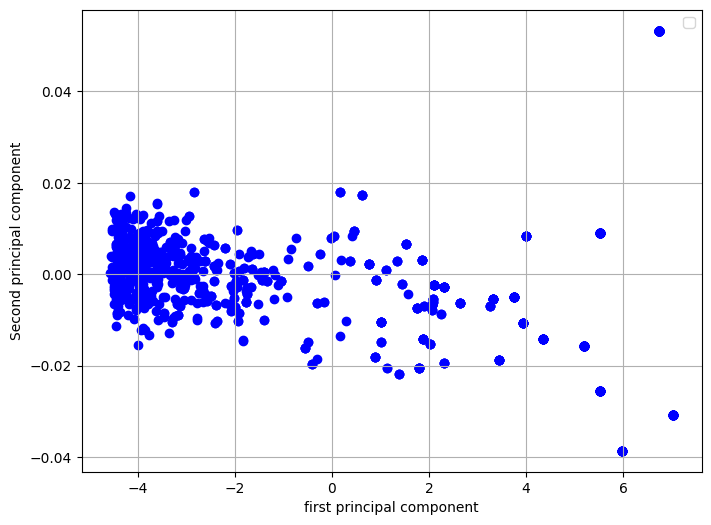

各次元の寄与率: [9.99776776e-01 1.99172989e-05]
累積寄与率: 0.9997966930299977


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   first principal component  second principal component
0                   5.598052                    0.000863
1                  -3.488146                    0.001301
2                   1.199643                   -0.004642


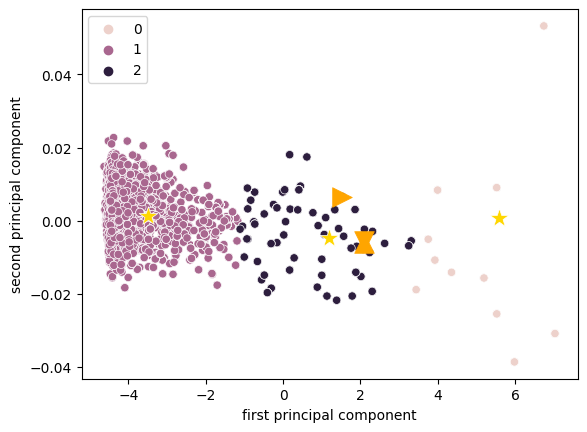

{'with', 'hi', 'in', 'of', 'the', 'and', 'a', 'as', 'wa', 'he', 'to'}
{'', 'misao', 'point', 'hand', 'ki', 'serolog', 'central', 'proceed', 'happi', 'everi', 'denounc', "keppen'", 'commod', 'author', "chie'", 'scene', 'shofukai', 'shonosuk', 'zhao', 'carbin', 'jay', 'pursu', 'adjac', '25th', 'darg', '1881', 'red', 'keenli', 'autumn', 'fulfil', 'ship', 'realiz', 'limit', 'sail', 'fishermen', 'cours', "kikkawa'", 'vomit', 'kawashima', 'pillar', 'news', 'toshiyuki', 'descript', 'kesaki', 'hit', 'reorder', 'bookstor', 'power', 'tohoku', 'shohei', 'give', 'dementia', 'obviou', 'komagom', 'studio', 'toshio', 'recognit', 'differ', 'carv', 'partli', 'telegram', 'recogn', 'occas', 'here', 'asahi', 'circumst', 'annot', 'bacteri', 'kai', 'chie', 'cheer', 'redon', 'brain', 'trial', 'ridg', 'onc', 'conceal', 'enact', '21st', 'kogoro', 'prussian', 'blame', 'heart', '22', 'british-styl', 'ecuador', 'nationalist', 'sash', 'showa', 'gakko', 'u', 'loan', 'mind-boggl', 'yozo', 'ground', 'tomokuma', 'depa

In [9]:
#main
path='./raw_text3.txt'
eliminate_set=set()
word_matrix,word_list=make_word_matrix(path)
transformed_matrix=do_pca(word_matrix)
cluster=clustering(transformed_matrix,word_list,True)

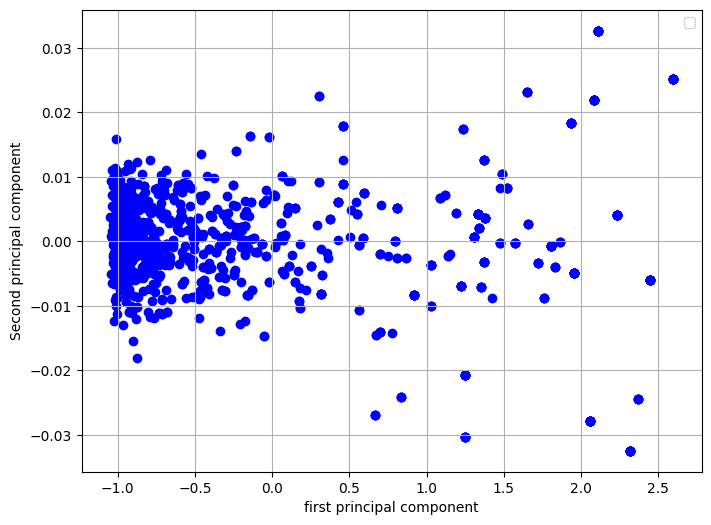

各次元の寄与率: [9.96990285e-01 8.41801006e-05]
累積寄与率: 0.9970744653766128


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   first principal component  second principal component
0                   0.256350                   -0.001356
1                   1.739950                    0.000679
2                  -0.783849                    0.000237


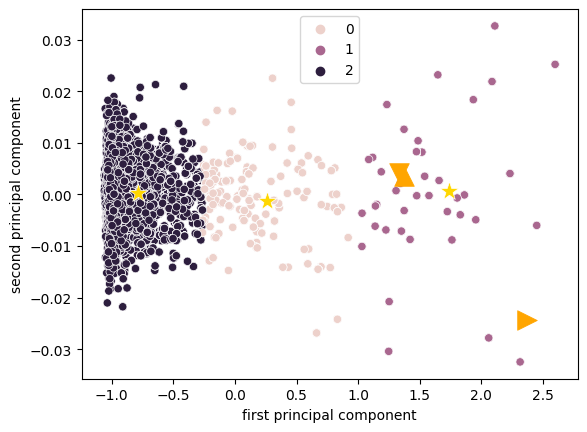

{'pathogen', 'octob', 'polit', 'over', 'hand', 'due', 'own', 'new', 'result', 'chines', 'onli', 'english', 'born', 'month', 'himself', 'may', 'all', 'tokyo', 'wrote', 'medicin', 'hous', 'son', 'where', 'student', 'so', 'learn', 'includ', 'faction', 'read', 'use', 'they', 'literatur', 'june', 'return', "soseki'", 'move', 'second', 'day', 'war', 'two', 'befor', 'member', 'live', 'their', 'emperor', 'asahi', 'studi', 'you', 'cabinet', 'annex', 'fever', 'peopl', 'death', 'three', 'state', 'world', 'korean', 'becom', 'research', 'about', 'septemb', 'follow', 'govern', 'order', 'into', 'rockefel', 'now', '-', "ito'", 'serv', 'becaus', 'ask', 'visit', 'did', 'write', 'same', 'no', 'ha', 'univers', 'even', 'institut', 'them', 'presid', 'there', 'would', 'receiv', 'daughter', 'are', 'kaoru', 'assassin', 'began', 'parti', 'name', 'novemb', 'diseas', 'life', 'nation', 'out', 'mother', 'establish', 'yen', 'form', 'imperi', 'die', 'well', 'mani', 'her', 'high', 'or', 'yellow', 'under', 'one', 'betw

In [10]:
# 追加実験（繰り返し1回目）
eliminate_set2=define_eliminate_set(cluster,"with")

if "noguchi" in eliminate_set2:
  eliminate_set2.remove("noguchi")
if "ito" in eliminate_set2:
  eliminate_set2.remove("ito")
if "soseki" in eliminate_set2:
  eliminate_set2.remove("soseki")

eliminate_set.update(eliminate_set2)
word_matrix,word_list=make_word_matrix(path,eliminate_set)
transformed_matrix=do_pca(word_matrix)
cluster=clustering(transformed_matrix,word_list,True)

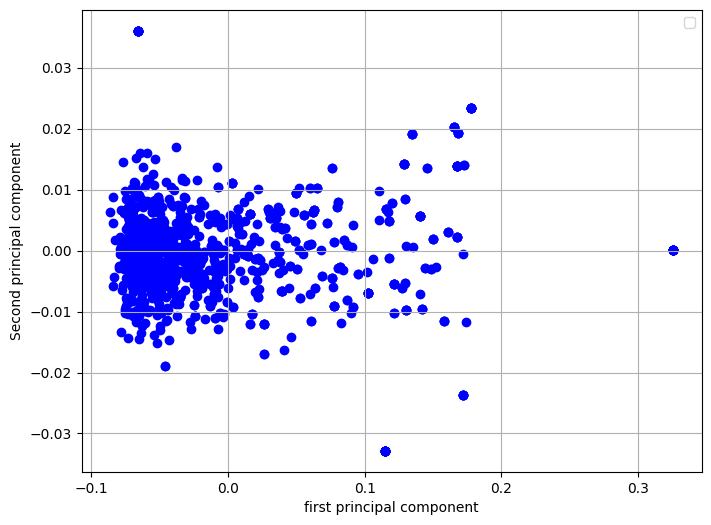

各次元の寄与率: [0.6349275 0.0079117]
累積寄与率: 0.6428392054891089


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   first principal component  second principal component
0                   0.144167                   -0.000725
1                  -0.053541                    0.000211
2                   0.026786                   -0.000018


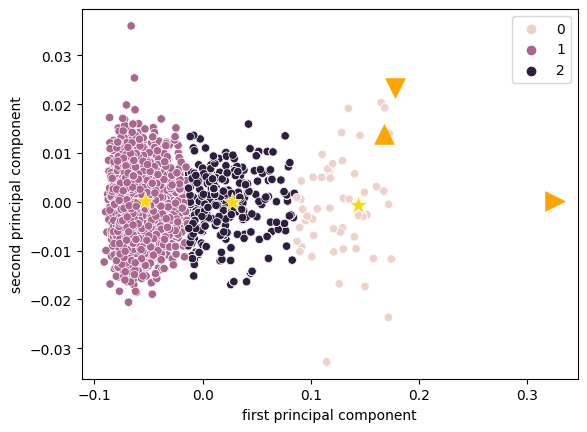

{'imperi', 'polit', 'second', 'day', 'war', 'no', 'univers', 'even', 'institut', 'emperor', 'yellow', 'studi', 'onli', 'there', 'you', 'english', 'cabinet', 'fever', 'one', 'peopl', "soseki'", 'himself', 'would', 'may', 'soseki', 'tokyo', 'japanes', 'are', 'hous', 'noguchi', 'state', 'korean', 'research', 'about', 'govern', 'student', 'so', 'natsum', '-', 'prime', 'parti', "ito'", 'becaus', 'name', 'prefectur', 'dure', 'did', 'foreign', 'they', 'same', 'write', 'medic', 'return', 'ito', 'establish'}
{'', 'misao', 'point', 'ki', 'serolog', 'central', 'proceed', 'happi', 'everi', 'denounc', "keppen'", 'commod', 'author', "chie'", 'scene', 'shofukai', 'shonosuk', 'zhao', 'carbin', 'jay', 'pursu', 'adjac', '25th', 'darg', '1881', 'red', 'keenli', 'autumn', 'fulfil', 'ship', 'realiz', 'limit', 'sail', 'fishermen', 'cours', "kikkawa'", 'vomit', 'kawashima', 'pillar', 'news', 'toshiyuki', 'descript', 'kesaki', 'hit', 'reorder', 'bookstor', 'tohoku', 'shohei', 'give', 'dementia', 'obviou', 'ko

In [11]:
# 追加実験（繰り返し2回目）
eliminate_set2=define_eliminate_set(cluster,"him")

if "noguchi" in eliminate_set2:
  eliminate_set2.remove("noguchi")
if "ito" in eliminate_set2:
  eliminate_set2.remove("ito")
if "soseki" in eliminate_set2:
  eliminate_set2.remove("soseki")

eliminate_set.update(eliminate_set2)
word_matrix,word_list=make_word_matrix(path,eliminate_set)
transformed_matrix=do_pca(word_matrix)
cluster=clustering(transformed_matrix,word_list,True)